<a href="https://www.kaggle.com/code/lorenzojayd/birdclef-2024-beginner-guide-model-training?scriptVersionId=176691771" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

The purpose of this notebook is twofold; to serve as a baseline entry for me, and to serve as an educational guide for those who may be undertaking a competition of this complexity for the first time. You are most welcome to use this notebook as a guide to build upon. Feel free to comment on things you find incorrect or could be improved.

# Import Libraries

In [1]:
# Standard data manipulation libraries
import numpy as np
import pandas as pd
import os
import joblib # Used for exporting and importing trained models
import librosa # Used for processing audio

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import Audio # Used for displaying an interactive audio player

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
df_metadata = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')
df_ebird_taxonomy = pd.read_csv('/kaggle/input/birdclef-2024/eBird_Taxonomy_v2021.csv')
sample_submission = pd.read_csv('/kaggle/input/birdclef-2024/sample_submission.csv')

In [3]:
# Metadata summary
display(df_metadata.head(2))
display(df_metadata.info())

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  filename          24459 non-null  object 
dtypes: float64(3), object(9)
memory usage: 2.2+ MB


None

This tells us the training data has **24459 entries**

In [4]:
# Taxonomy data summary
display(df_ebird_taxonomy.head(2))
display(df_ebird_taxonomy.info())

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16753 entries, 0 to 16752
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TAXON_ORDER       16753 non-null  int64 
 1   CATEGORY          16753 non-null  object
 2   SPECIES_CODE      16753 non-null  object
 3   PRIMARY_COM_NAME  16753 non-null  object
 4   SCI_NAME          16753 non-null  object
 5   ORDER1            16751 non-null  object
 6   FAMILY            16740 non-null  object
 7   SPECIES_GROUP     216 non-null    object
 8   REPORT_AS         3876 non-null   object
dtypes: int64(1), object(8)
memory usage: 1.2+ MB


None

In [5]:
# Sample submission file
display(sample_submission.head(2))

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


From the sample submission file, we see that for each test soundscape, we need to predict the **probability** of the bird species in the audio being each unique class. Moreover, the test soundscapes are 4 minutes each with each soundscape recording possibly containing multiple bird species. We therefore need to split each soundscape into 5-second intervals and make a prediction for each interval. This means that for each 4-minute soundscape, there will be 48 predictions ($4mins / 5secs = 48$). The row_id for each prediction will be in the format; "soundscape_[soundscape_id]_[end_time]" with [end time] referring to the interval of the soundscape.

# Exploratory Data Analysis

In [6]:
# Checking for null values
print('Metadata')
display(df_metadata.isnull().sum())
print('-' * 25)
print('Taxonomy Data')
display(df_ebird_taxonomy.isnull().sum())

Metadata


primary_label         0
secondary_labels      0
type                  0
latitude            378
longitude           378
scientific_name       0
common_name           0
author                0
license               0
rating                0
url                   0
filename              0
dtype: int64

-------------------------
Taxonomy Data


TAXON_ORDER             0
CATEGORY                0
SPECIES_CODE            0
PRIMARY_COM_NAME        0
SCI_NAME                0
ORDER1                  2
FAMILY                 13
SPECIES_GROUP       16537
REPORT_AS           12877
dtype: int64

We can see that there are several null values but seeing as we will using the audio files only for training, we will ignore these features

Total unique bird species:  182 



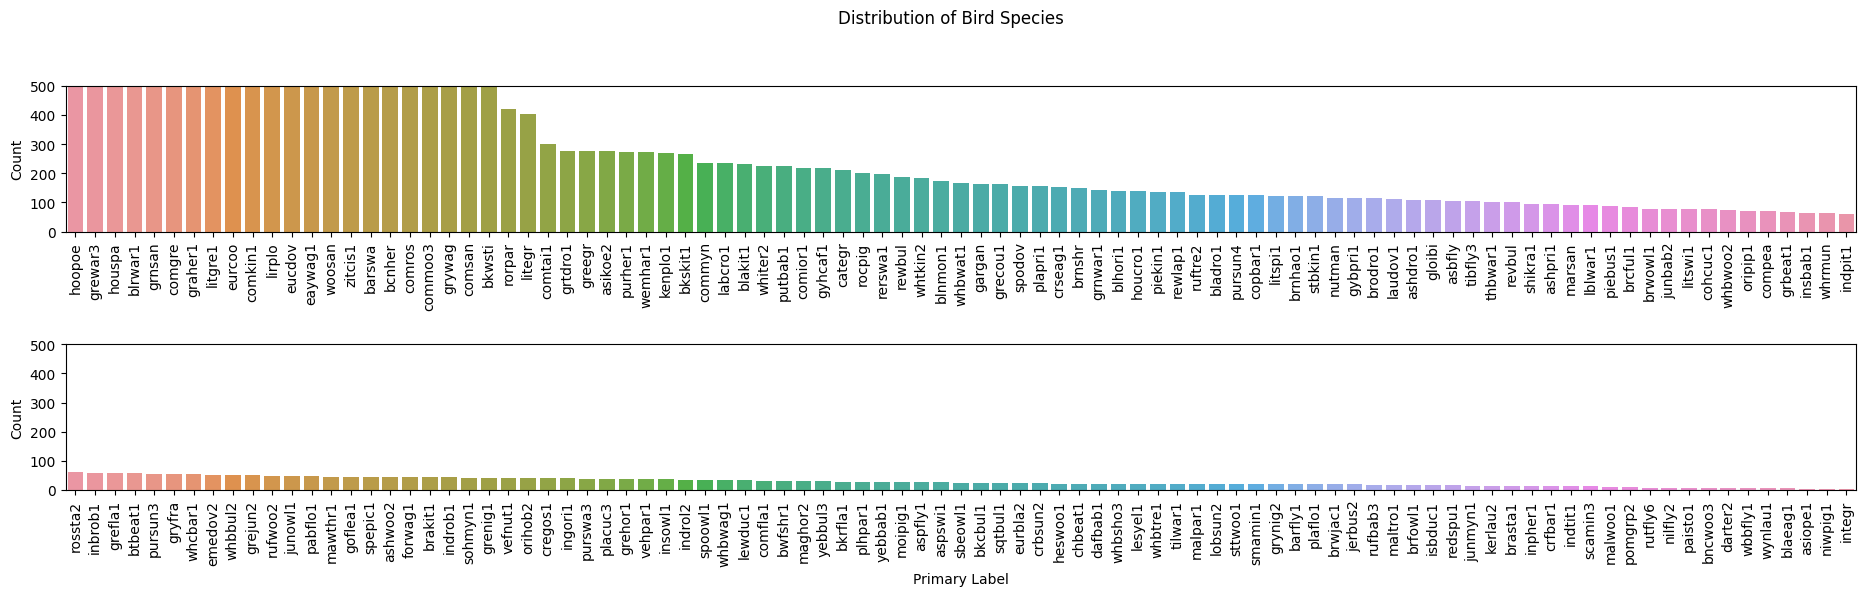

In [7]:
bird_freq = df_metadata['primary_label'].value_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 6), sharey = True)
fig.tight_layout(pad = 6)

sns.barplot(x = bird_freq[0:91].index, y = bird_freq[0:91].values, ax = ax1)
ax1.set_xticklabels(bird_freq[0:91].index, rotation = 90)
ax1.set_ylim(0, 500)
ax1.set_xlabel('')
ax1.set_ylabel('Count')

sns.barplot(x = bird_freq[91:].index, y = bird_freq[91:].values, ax = ax2)
ax2.set_xticklabels(bird_freq[91:].index, rotation = 90)
ax2.set_ylim(0, 500)
ax2.set_xlabel('Primary Label')
ax2.set_ylabel('Count')

fig.suptitle('Distribution of Bird Species')

fig.show()

# Prints the total number of unique bird species
print('Total unique bird species: ', len(df_metadata['primary_label'].unique()), '\n')

From the figure above, we observe a major class imbalance where 12% (22 out of 182) of the unique species make up 45% (11000 out of 24459) of the total population. To mitigate the potentially skewed prediction this will bring, we can use an **oversampler** to equalize the number of samples between each class.

In [8]:
# Plots the bird species according to their geographical location (latitude, longitude)
fig = px.scatter_mapbox(df_metadata, lat = 'latitude', lon = 'longitude', color = 'primary_label', title = 'Geographical Distribution of Bird Species', zoom = 0, height = 600, width = 1000, mapbox_style = 'open-street-map')
fig.show()

## Sample audio file

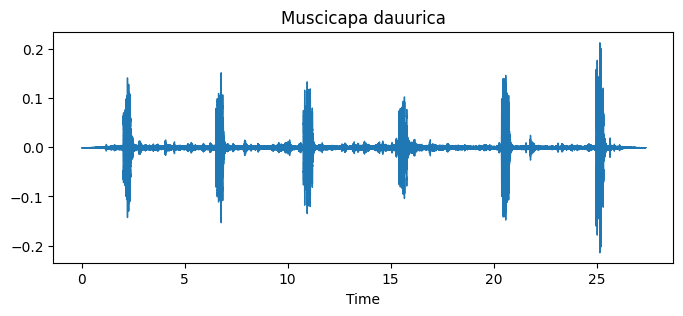

In [9]:
# Function for displaying a waveform
def plot_waveform(input_path, title = 'Waveform'):
    waveform, sample_rate = librosa.load(input_path)
    
    fig, ax = plt.subplots(1,1, figsize = (8, 3))
    librosa.display.waveshow(waveform, sr=sample_rate, ax=ax)
    plt.title(title)
    plt.show()

# Audio player
display(Audio('/kaggle/input/birdclef-2024/train_audio/asbfly/XC134896.ogg'))

# Plots the waveform of one of the training audio files
plot_waveform('/kaggle/input/birdclef-2024/train_audio/asbfly/XC134896.ogg', 'Muscicapa dauurica')

Each training audio file is a unique clean recording of a single bird species.

# Data Wrangling

In [10]:
# Adding the full file path to the metadata
audio_dir_path = '/kaggle/input/birdclef-2024/train_audio/'
df_metadata['file_path'] = audio_dir_path + df_metadata['filename']
df_metadata.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,file_path
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,/kaggle/input/birdclef-2024/train_audio/asbfly...


## Feature Engineering

To be able to use a classifier, we must extract or create **numerical** features from the audio files. One way to do that is by extracting the Mel-Frequency Cepstral Coefficients (MFFCs) of an audio file. MFFCs are a way to numerically represent the spectral characteristics of an audio file.

In [11]:
def get_coefficients(input_path):
    # Returns the Mel-Frequency Cepstral Coefficients (MFCCs) from an audio file
    
    # loading the audio file into librosa which returns its waveform and sample_rate
    waveform, sample_rate = librosa.load(input_path)
    
    # Extracting the MFCCs from the waveform
    mfccs = librosa.feature.mfcc(y = waveform, sr = sample_rate, n_mfcc = 40)
    scaled_mfccs = np.mean(mfccs.T, axis = 0)
    
    return scaled_mfccs

def feature_engineer(df):
    # This function returns a dataframe containing the MFFCs of each audio file in the dataframe
    
    # Empty array where we will store the new features (MFCCs)
    new_features = []
    
    # From earlier, we added the full file path of each training audio file to the metadata.
    # The purpose of that was so we can iterate over the metadata instead of having to perform a crawl on the training directory
    for i, file in df.iterrows():
        input_path = file['file_path']
        
        # Using the get_coefficients function to extract the MFCCs
        coefficients = get_coefficients(input_path)
        new_features.append(coefficients)
    
    # hard coding the feature names for the MFCCs
    train_columns = np.arange(0, 40)
    train_columns_str = [str(name) for name in train_columns]
    
    df_train = pd.DataFrame(new_features, columns = train_columns_str)
    df_train = pd.concat([df_train, df['primary_label']], axis = 1)
    
    return df_train

In [12]:
# Running the feature engineering functions
df_train = feature_engineer(df_metadata)

In [13]:
# Summary of the training dataset with the new features
display(df_train.head(2))
display(df_train['primary_label'].value_counts())

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,primary_label
0,-641.388123,-159.212784,0.558693,25.385014,-11.057750,11.541111,-9.688829,7.185257,-3.899643,2.793417,...,3.028741,-2.228943,0.149655,-2.683640,2.803632,-0.478069,0.966041,-1.983671,1.417072,asbfly
1,-423.791840,78.445854,18.841692,8.901731,-13.212008,5.555706,-4.813046,4.523173,-4.196108,6.006501,...,0.462334,-0.754692,0.755701,-1.693211,0.561997,-2.509030,1.219976,-2.602253,0.463633,asbfly


primary_label
hoopoe     500
grewar3    500
houspa     500
blrwar1    500
grnsan     500
          ... 
wynlau1      6
blaeag1      6
asiope1      5
niwpig1      5
integr       5
Name: count, Length: 182, dtype: int64

## Label Encoding

The classifier will expect numerical classes. We therefore need to encode the class names into numerical classes by using a **label encoder**.

In [14]:
# Extract the unique labels from the metadata
original_labels = df_metadata['primary_label'].unique()

# Fitting the label encoder to the list of labels from the metadata
label_encoder = LabelEncoder()
label_encoder.fit(original_labels)

# encoding the primary_labels
encoded_labels = label_encoder.transform(df_train['primary_label'])
df_train['encoded_label'] = encoded_labels

display(df_train['encoded_label'].value_counts())

encoded_label
80     500
70     500
82     500
20     500
71     500
      ... 
178      6
16       6
5        5
119      5
92       5
Name: count, Length: 182, dtype: int64

In [15]:
# Splitting the training dataset into X(independent features) and y(dependent/target feature)
X, y = df_train.drop(columns = ['primary_label', 'encoded_label']), df_train['encoded_label']

## Oversampling
As mentioned in the EDA section, oversampling is required to address the class imbalance.

In [16]:
# initializing the oversampler
sampler = RandomOverSampler(random_state = 0)

# fit oversampler and resample
X_resampled, y_resampled = sampler.fit_resample(X, y)

df_train_resampled = pd.DataFrame(X_resampled)
df_train_resampled['encoded_label'] = y_resampled
display(df_train_resampled.head(2))
display(df_train_resampled.info())

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,encoded_label
0,-641.388123,-159.212784,0.558693,25.385014,-11.057750,11.541111,-9.688829,7.185257,-3.899643,2.793417,...,3.028741,-2.228943,0.149655,-2.683640,2.803632,-0.478069,0.966041,-1.983671,1.417072,0
1,-423.791840,78.445854,18.841692,8.901731,-13.212008,5.555706,-4.813046,4.523173,-4.196108,6.006501,...,0.462334,-0.754692,0.755701,-1.693211,0.561997,-2.509030,1.219976,-2.602253,0.463633,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91000 entries, 0 to 90999
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   0              91000 non-null  float32
 1   1              91000 non-null  float32
 2   2              91000 non-null  float32
 3   3              91000 non-null  float32
 4   4              91000 non-null  float32
 5   5              91000 non-null  float32
 6   6              91000 non-null  float32
 7   7              91000 non-null  float32
 8   8              91000 non-null  float32
 9   9              91000 non-null  float32
 10  10             91000 non-null  float32
 11  11             91000 non-null  float32
 12  12             91000 non-null  float32
 13  13             91000 non-null  float32
 14  14             91000 non-null  float32
 15  15             91000 non-null  float32
 16  16             91000 non-null  float32
 17  17             91000 non-null  float32
 18  18    

None

In [17]:
# Splitting the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 12)

# Model Training

We will use XGBClassifier as our classifier using only the default parameters and hyperparameters. You may utilize a grid search or random search algorithm to tune the hyperparameters.

In [18]:
# Initializing XGBClassifier
# NOTE: IF you will be running this notebook without a GPU accelerator, remove the tree_method = 'gpu_hist' parameter below. This argument ensures that XGBoost runs the notebook using a GPU.
clf = XGBClassifier(tree_method = 'gpu_hist')

# Training the model
clf.fit(X_train, y_train)

# Saving/exporting the model
joblib.dump(clf, 'clf.joblib')

['clf.joblib']

# Simple Model Evaluation

In [19]:
# making predictions on the test set
y_predictions = clf.predict(X_test)

# accuracy score of the model
accuracy = accuracy_score(y_predictions, y_test)
print('Accuracy score: ', accuracy)

Accuracy score:  0.8753296703296704


# What's next?
After saving the model, we can use it to predict and submit in a separate notebook: [Inferring Guide](https://www.kaggle.com/code/lorenzojayd/birdclef-2024-beginner-guide-inferring/notebook)

As for improvements, you may look at different feature engineering techniques such as turning the audio chunks into spectograms and using computer vision libraries to train neural networks. You may also experiment with tuning the hyperparameters of the classifier, or even use different classfying algorithms such as random forests, or use different libraries such as LGBM or Scikit-learn.